In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.utils import image_dataset_from_directory
import tensorflow as tf
# Directories
train_dirs = [
    '/content/drive/MyDrive/ProjetoIA/dataset/train1',
    '/content/drive/MyDrive/ProjetoIA/dataset/train2',
    '/content/drive/MyDrive/ProjetoIA/dataset/train4',
    '/content/drive/MyDrive/ProjetoIA/dataset/train5'
]
validation_dir = '/content/drive/MyDrive/ProjetoIA/dataset/train3'
test_dir = '/content/drive/MyDrive/ProjetoIA/dataset/test'

# Parameters
IMG_SIZE = 150
BATCH_SIZE = 32

# Function to load datasets from multiple directories and concatenate them
def load_and_concatenate_datasets(directories, img_size, batch_size):
    datasets = []
    for directory in directories:
        dataset = image_dataset_from_directory(
            directory,
            image_size=(img_size, img_size),
            batch_size=batch_size
        )
        datasets.append(dataset)
    return datasets

# Load train datasets and concatenate
train_datasets = load_and_concatenate_datasets(train_dirs, IMG_SIZE, BATCH_SIZE)
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets)

# Load validation and test datasets
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Extract class names from one of the datasets
example_dataset = image_dataset_from_directory(
    train_dirs[0],
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
class_names = example_dataset.class_names
print(class_names)

Found 10400 files belonging to 10 classes.
Found 9600 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 1 classes.
Found 10400 files belonging to 10 classes.
['000_airplane', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '009_truck']


In [3]:
#Let us first load the VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))



58889256/58889256 [==============================] - 4s 0us/step


In [4]:
from tensorflow import keras
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)# tem q se juntar a lista pra caber na rede

#This is the function that we useto compute the output of the
#feature extraction section for each of the datasets

In [5]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 25ms/step


In [34]:
#Now, we build a dense network
#that will play the role of the
#classification section
#Because models behave just like layers, we can use them as any other
#layers to build a new model. In this case, we want to use conv_base
#and model to build the full model:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(4, 4, 512))#cada imagem gera um cubo
x = data_augmentation(inputs)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)#desliga 20% por entrada
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [35]:
#Now, the train process, which,
#in this case, doesn’t take long.
#So, you can run it yourself in
#the class

model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=['accuracy'])
history = model.fit(
train_features, train_labels,
epochs=25,
validation_data=(val_features, val_labels))


Epoch 1/25
1250/1250 [==============================] - 5s 3ms/step - loss: 4.9569 - accuracy: 0.6134 - val_loss: 2.2030 - val_accuracy: 0.7847
Epoch 2/25
1250/1250 [==============================] - 4s 3ms/step - loss: 2.2889 - accuracy: 0.7863 - val_loss: 1.8418 - val_accuracy: 0.8155
Epoch 3/25
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7572 - accuracy: 0.8227 - val_loss: 1.6025 - val_accuracy: 0.8366
Epoch 4/25
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4555 - accuracy: 0.8432 - val_loss: 1.5242 - val_accuracy: 0.8456
Epoch 5/25
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2318 - accuracy: 0.8602 - val_loss: 1.4596 - val_accuracy: 0.8513
Epoch 6/25
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0430 - accuracy: 0.8730 - val_loss: 1.4286 - val_accuracy: 0.8548
Epoch 7/25
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9447 - accuracy: 0.8788 - val_loss: 1.4204 - val_accuracy:

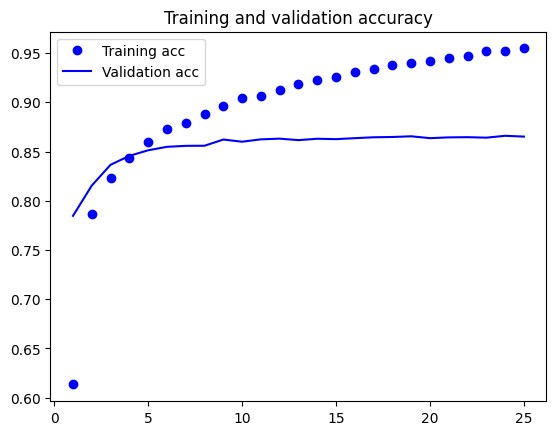

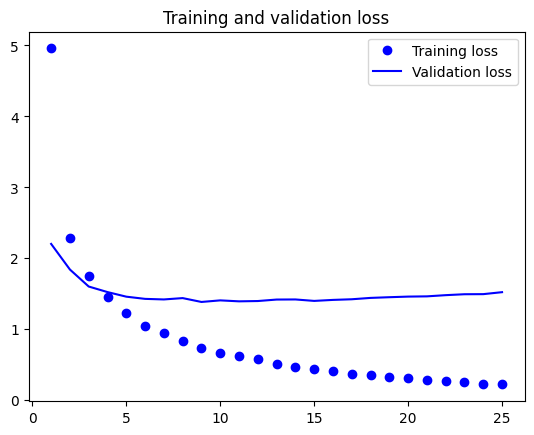

In [36]:
#Displaying curves of loss and accuracy

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:

from keras import models
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

In [38]:
full_model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=['accuracy'])

In [41]:
#• Now, we save the model
full_model.save('/content/drive/MyDrive/ProjetoIA/models/CNN_TL_FE_with_data_augmentation.h5')

In [13]:
#We can later load it and test it:
from tensorflow import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/ProjetoIA/models/CNN_TL_FE_without_data_augmentation.h5')
# case been loaded change bellow full_model->loaded_model

In [40]:
# case been loaded change bellow full_model->loaded_model
val_loss, val_acc = full_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 [==============================] - 14s 43ms/step - loss: 1.5230 - accuracy: 0.8652
val_acc: 0.8651999831199646
